In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import numpy as np
from tqdm import tqdm
import seaborn as sns
rng = np.random.default_rng(seed=42)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [33]:
df_b2b_results_fixed = pd.read_csv("output/01_b2b_forecast_complete.csv")

# Load the grid and land use data
relevant_types = ["commercial", "industrial", "retail", "residential"]
osm_landuse_hann = gpd.read_file("input/osm_landuse_region_hannover.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
landuse_filtered = osm_landuse_hann[osm_landuse_hann["fclass"].isin(relevant_types)]

final_grid_h = gpd.read_file("input/final_grid_250_region_results_update.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

#Convert Columns with Numeric-looking Strings to Proper Numeric Format
for col in final_grid_h.select_dtypes(include=["object"]).columns:
    if col != final_grid_h.geometry.name:
        try:
            converted = pd.to_numeric(final_grid_h[col], errors="coerce")
            if converted.notna().sum() > 0.9 * len(final_grid_h):  
                final_grid_h[col] = converted
        except Exception as e:
            print(e)
            pass 

C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_12292\3239811437.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [mpatches.Patch(color=color, label=labels[label], edgecolor='k') for label, color in colors.items()]
C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_12292\3239811437.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_classes))  # Farbschema für verschiedene Kategorien


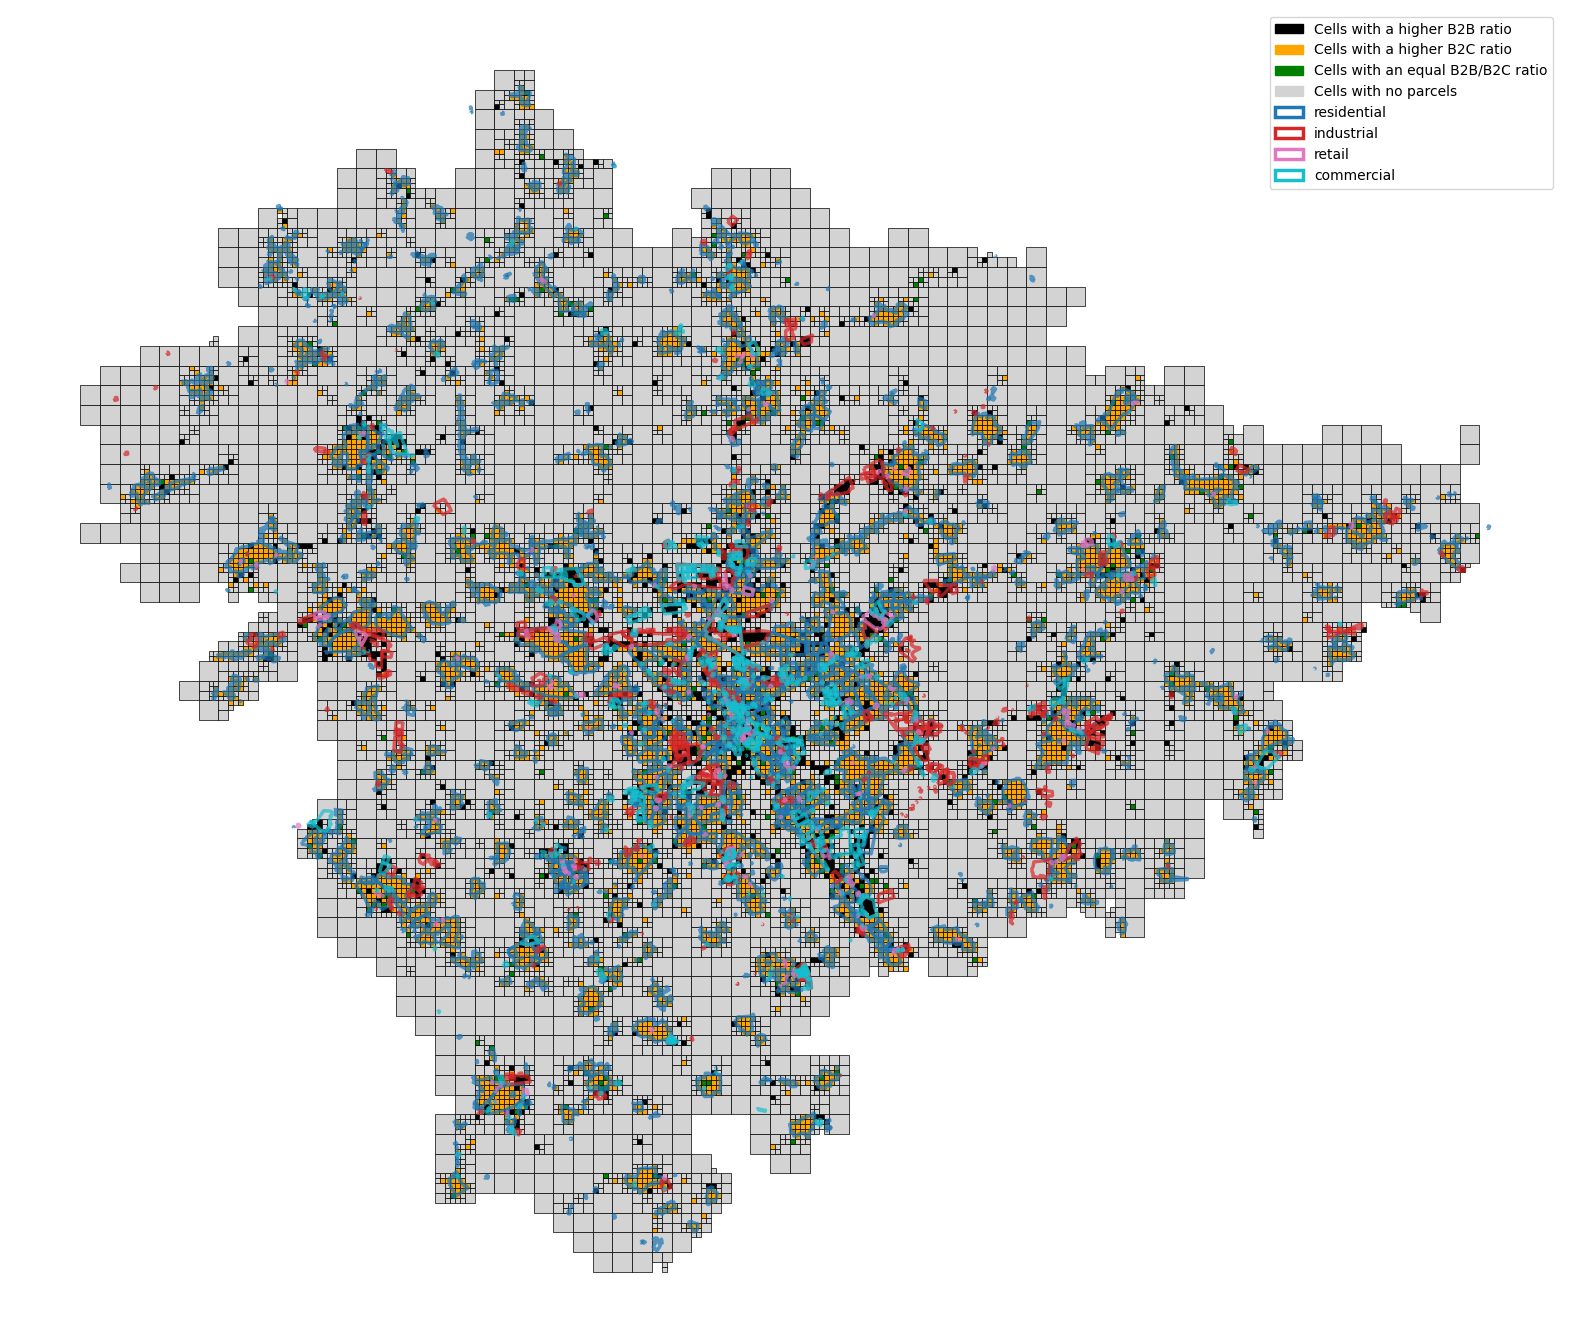

In [29]:
# Define a custom colormap for delivery types
colors = {
    'b2b': 'black',
    'b2c': 'orange',
    'equal': 'green',
    'no': 'lightgray'  # White for "Cells with no parcels"
}

# Define new labels for the legend
labels = {
    'b2b': 'Cells with a higher B2B ratio',
    'b2c': 'Cells with a higher B2C ratio',
    'equal': 'Cells with an equal B2B/B2C ratio',
    'no': 'Cells with no parcels'
}

fig, ax = plt.subplots(figsize=(20, 20))

# Plot the grid cells with their delivery types
final_grid_h.plot(ax=ax, color=final_grid_h['delivery_type'].map(colors), edgecolor='k', linewidth=0.5)

# Create custom legend for delivery types
legend_handles = [mpatches.Patch(color=color, label=labels[label], edgecolor='k') for label, color in colors.items()]

# Einzigartige fclass-Werte abrufen und Farben zuweisen
unique_classes = landuse_filtered["fclass"].unique()
cmap = plt.cm.get_cmap("tab10", len(unique_classes))  # Farbschema für verschiedene Kategorien
color_dict = {cls: cmap(i) for i, cls in enumerate(unique_classes)}

# Polygone einzeln plotten mit spezifischen Randfarben und zur Legende hinzufügen
for cls in unique_classes:
    subset = landuse_filtered[landuse_filtered["fclass"] == cls]
    subset.plot(ax=ax, edgecolor=color_dict[cls], facecolor="none", linewidth=2.5, alpha = 0.7)

    # Legenden-Eintrag für die Landnutzungen
    legend_handles.append(mpatches.Patch(edgecolor=color_dict[cls], facecolor="none", label=cls, linewidth=2.5))

# Add legend with both delivery types and landuse labels
ax.legend(handles=legend_handles, loc='upper right')

# Remove the frame (spines) around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# If you also want to remove the x and y axis ticks and labels:
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()
# fig.savefig('b2b_res.png', dpi=300 , bbox_inches='tight')

In [35]:
# Filter: Keep only grid cells with a positive estimated parcel volume
# (e.g., based on approximated DHL data)
final_grid_h_filter = final_grid_h[final_grid_h["total_coun"] > 0].copy()

# Step 1: Normalize B2B ratio to range [0, 1]
# Converts from percent representation (0–100) to decimal (0.0–1.0)
final_grid_h_filter["b2b_ratio_norm"] = final_grid_h_filter["b2b_ratio"] / 100

# Step 2: Compute the weighted B2B contribution per grid cell
# Each cell's B2B ratio is weighted by its estimated parcel volume
final_grid_h_filter["weighted_b2b"] = (
    final_grid_h_filter["b2b_ratio_norm"] * final_grid_h_filter["total_coun"]
)

# Step 3: Aggregate to postal code level
# Compute weighted average B2B share for each postal code (PLZ)
plz_b2b_summary = (
    final_grid_h_filter
    .groupby("postal_cod")
    .agg(
        total_count=("total_coun", "sum"),             # Sum of parcel volumes per postal code
        weighted_b2b_sum=("weighted_b2b", "sum")       # Sum of weighted B2B contributions
    )
)

# Step 4: Compute the weighted average B2B share per postal code
plz_b2b_summary["b2b_ratio_weighted"] = (
    plz_b2b_summary["weighted_b2b_sum"] / plz_b2b_summary["total_count"]
)

# Step 5 (optional): Convert to percentage format (0–100%)
plz_b2b_summary["b2b_ratio_weighted_percent"] = (
    plz_b2b_summary["b2b_ratio_weighted"] * 100
)

# Step 6: Compute the total weighted national B2B share across all grid cells
total_weighted_b2b = final_grid_h_filter["weighted_b2b"].sum()
total_packages = final_grid_h_filter["total_coun"].sum()
b2b_ratio_overall = total_weighted_b2b / total_packages
b2b_ratio_overall_percent = b2b_ratio_overall * 100

# Step 7: Output results
print("Weighted national B2B share across all grid cells: {:.2f}%".format(b2b_ratio_overall_percent))
print("\nWeighted B2B share by postal code (PLZ):")
print(plz_b2b_summary[["b2b_ratio_weighted_percent"]].round(2))


Weighted national B2B share across all grid cells: 24.81%

Weighted B2B share by postal code (PLZ):
            b2b_ratio_weighted_percent
postal_cod                            
30159                            59.74
30161                            38.83
30163                            28.43
30165                            30.82
30167                            36.74
30169                            33.96
30171                            18.28
30173                            25.88
30175                            34.60
30177                            15.26
30179                            28.92
30419                            16.25
30449                            28.79
30451                            30.51
30453                            25.14
30455                            15.87
30457                            16.17
30459                            17.52
30519                            26.68
30521                            30.77
30539                            37.97
305

In [ ]:
"""
Adjusting Estimated B2B Ratios in Hannover Grid to Match National B2B Targets
------------------------------------------------------------------------------------

Context:
--------
We estimate the share of B2B parcel volume per cell in a spatial grid over the Hannover region 
(called `final_grid_h_filter`). The estimation is based on a simple regression model using
population and company density per cell.

However, these local cell-level B2B estimates (`b2b_ratio_norm`) may not match the known 
national-level B2B share (e.g., from official data sources), as the underlying regression model 
only provides a simplified approximation. Its primary purpose is to generate a realistic first-pass 
estimate of spatial B2B patterns, which can then be calibrated more accurately.

Goal:
-----
This script adjusts each cell's B2B ratio by a correction factor (α), such that the 
national B2B target for a given year is approached when averaging over all grid cells.
This is done using a **genetic algorithm (GA)** for optimization.

Importantly, the averaging is **weighted by the total parcel volume per cell**, 
which was previously estimated using real DHL shipment data.
This ensures that high-volume cells contribute more to the national-level correction,
and that the outcome reflects the true spatial parcel distribution more accurately.

Each year has its own target B2B share (either observed or projected). For each year, 
we run the GA to find a vector of multiplicative adjustment factors for each cell. 
These are saved as new columns in the grid DataFrame, e.g.:
    - b2b_ratio_norm_adj_2021
    - b2b_ratio_norm_adj_2022
    - ...

Prerequisite:
-------------
- Load the Hannover grid (`final_grid_h_filter`)
- The grid must contain:
    * estimated B2B shares per cell (`b2b_ratio_norm`)
    * estimated total parcel volumes per cell based on DHL data (`total_coun`) → used as **weights**
    * qualitative fit assessment (`fit`: "too_high", "too_low", etc.)

"""

# === Prepare working copy ===
ga_corrected_b2b_gdf = final_grid_h.copy()
ga_corrected_b2b_gdf = ga_corrected_b2b_gdf[ga_corrected_b2b_gdf["total_coun"] > 0].reset_index(drop=True)

# Extract key columns for optimization
original_ratios = ga_corrected_b2b_gdf["b2b_ratio_norm"].values  # Initial B2B estimates
total_counts = ga_corrected_b2b_gdf["total_coun"].values         # Volume weights per cell
fit_labels = ga_corrected_b2b_gdf["fit"].values                  # Fit quality tags

# === Set up DEAP framework (only once) ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # We want to minimize error
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("mate", tools.cxBlend, alpha=0.3)            # Crossover operator
toolbox.register("mutate", tools.mutGaussian, mu=1.0, sigma=0.1, indpb=0.2)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection strategy

# === Define Fitness Function ===
def eval_b2b(individual):
    """
    Fitness function for evaluating a set of adjustment factors (alphas).
    It calculates:
    - the global error between national B2B target and the adjusted cell-level average
    - a penalty for deviations based on prior cell-specific fit knowledge
    """
    adjusted_ratios = np.clip(original_ratios * np.array(individual), 0, 1)
    weighted_b2b = adjusted_ratios * total_counts
    total_weighted = weighted_b2b.sum()
    total = total_counts.sum()
    global_error = abs((total_weighted / total) - TARGET_B2B)

    penalty = 0
    for i, alpha in enumerate(individual):
        delta = abs(alpha - 1)
        fit = fit_labels[i]

        # Penalty logic based on prior fit classification
        if fit == "correct":
            penalty += delta * (1.5 if alpha > 1 else 0.2)
        elif fit == "too_high":
            penalty += delta * (1.0 if alpha > 1 else 0.1)
        elif fit == "too_low":
            penalty += delta * (1.0 if alpha < 1 else 0.1)
        else:
            penalty += delta * 0.2

    return (global_error ** 2) * 3500 + penalty / len(individual),  # Return as a 1-tuple

toolbox.register("evaluate", eval_b2b)

# === Iterate over years ===
for index, row in tqdm(df_b2b_results_fixed.iterrows(), total=len(df_b2b_results_fixed), desc="Optimizing B2B per year"):
    year = row["Jahr"]
    target_b2b = row["Ist_B2B"] if row["Typ"] != "Prognose" else row["B2B_BoundedSigmoid"]
    TARGET_B2B = target_b2b / 100  # Convert from percent to fraction

    print(f"\n📅 Year {year} – Target B2B: {TARGET_B2B*100:.2f}%")

    # === Configure GA search space ===
    start_range = 0.2 if TARGET_B2B < 0.25 else 0.1  # Wider search for low targets
    max_range = 0.95
    step = 0.05
    success = False

    while start_range <= max_range:
        print(f"🌀 Trying alpha range ±{start_range:.2f}")

        # Define alpha bounds
        if TARGET_B2B < 0.25:
            min_alpha = max(0.25, 1 - start_range)
            max_alpha = 1.0
        else:
            min_alpha = 1 - start_range
            max_alpha = 1 + start_range

        def init_individual():
            """Initialize an individual with random alpha values within the search range."""
            return rng.uniform(min_alpha, max_alpha, size=len(original_ratios)).tolist()

        # Register individual and population initialization
        toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        # === Run GA ===
        pop = toolbox.population(n=50)
        hof = tools.HallOfFame(1)  # Best individual
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)

        pop, log = algorithms.eaSimple(
            population=pop,
            toolbox=toolbox,
            cxpb=0.5,      # Crossover probability
            mutpb=0.4,     # Mutation probability
            ngen=100,      # Number of generations
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        # === Post-GA evaluation ===
        best_alpha = np.array(hof[0])
        adjusted_ratios = np.clip(original_ratios * best_alpha, 0, 1)
        new_b2b_ratio = (adjusted_ratios * total_counts).sum() / total_counts.sum()

        print("🎯 Resulting B2B: {:.2f}%".format(new_b2b_ratio * 100))

        # Check if result is close enough to target
        if abs(new_b2b_ratio - TARGET_B2B) <= 0.005:
            ga_corrected_b2b_gdf[f"b2b_ratio_norm_adj_{year}"] = adjusted_ratios
            print(f"✅ Saved adjustments to column: b2b_ratio_norm_adj_{year}")
            success = True
            break

        # If not successful, expand the search range
        start_range += step

    if not success:
        print(f"❌ No satisfactory alpha combination found for year {year}.")

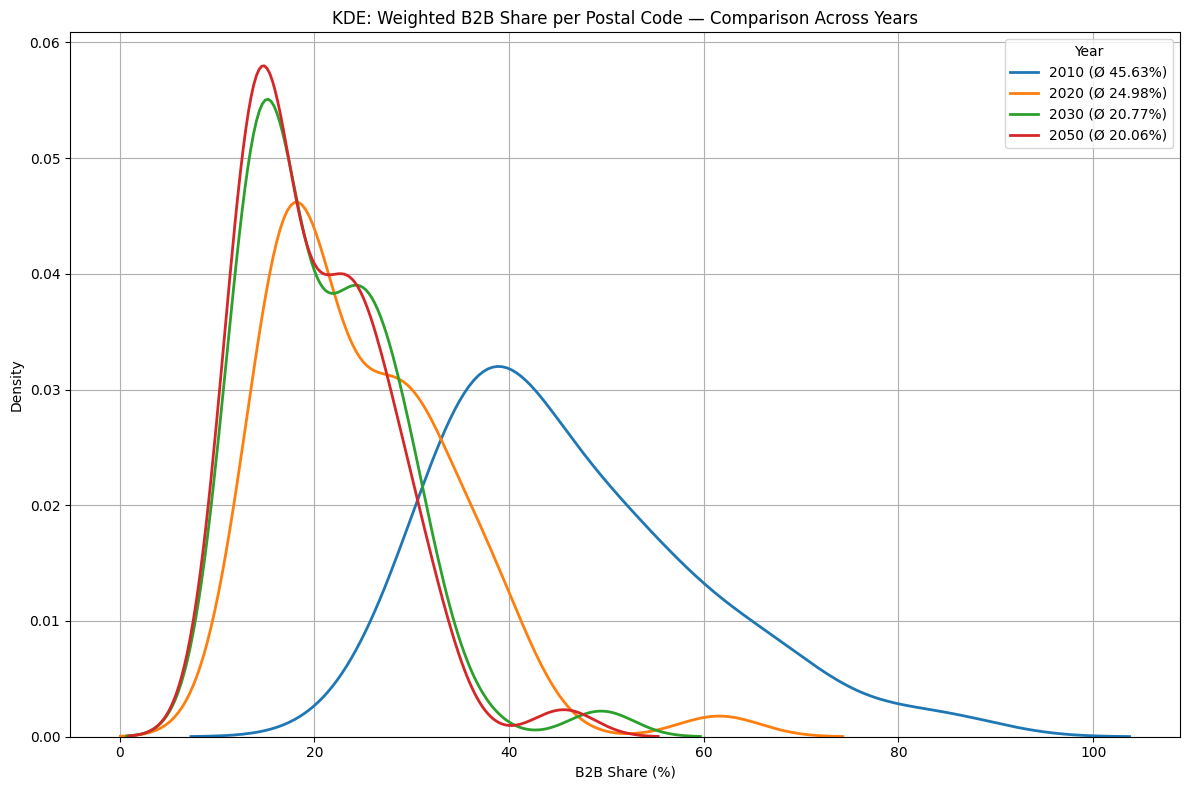

In [ ]:
# List of years to visualize
years_to_check = [2010, 2020, 2030, 2050]

plt.figure(figsize=(12, 8))

for year in years_to_check:
    col = f"b2b_ratio_norm_adj_{year}"

    if col not in ga_corrected_b2b_gdf.columns:
        print(f"Column '{col}' not found – skipping year {year}.")
        continue

    # Step 1: Compute weighted B2B values for the current year
    ga_corrected_b2b_gdf["weighted_b2b_adj_temp"] = (
        ga_corrected_b2b_gdf[col] * ga_corrected_b2b_gdf["total_coun"]
    )

    # Step 2: Aggregate B2B ratio to postal code level (PLZ)
    plz_b2b_ga = (
        ga_corrected_b2b_gdf
        .groupby("postal_cod")
        .agg(
            total_count=("total_coun", "sum"),
            weighted_b2b_sum=("weighted_b2b_adj_temp", "sum")
        )
    )
    plz_b2b_ga["b2b_ratio_weighted"] = (
        plz_b2b_ga["weighted_b2b_sum"] / plz_b2b_ga["total_count"]
    )
    plz_b2b_ga["b2b_ratio_weighted_percent"] = (
        plz_b2b_ga["b2b_ratio_weighted"] * 100
    )

    # Step 3: Compute total national B2B share for the year
    new_total_b2b = ga_corrected_b2b_gdf["weighted_b2b_adj_temp"].sum()
    new_total_packages = ga_corrected_b2b_gdf["total_coun"].sum()
    new_overall_percent = (new_total_b2b / new_total_packages) * 100

    # Step 4: KDE plot of weighted B2B values by postal code
    sns.kdeplot(
        plz_b2b_ga["b2b_ratio_weighted_percent"],
        label=f"{year} (Ø {new_overall_percent:.2f}%)",
        linewidth=2
    )

# Final formatting
plt.title("KDE: Weighted B2B Share per Postal Code — Comparison Across Years")
plt.xlabel("B2B Share (%)")
plt.ylabel("Density")
plt.grid(True)
plt.legend(title="Year", loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
ga_corrected_b2b_gdf.to_csv("output/04_ga_corrected_b2b_df.csv", index=False)